# Clasificar imágenes

In [39]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import torch
import os
import torch.nn.functional as F
from PIL import Image

In [40]:
def contarCorrectas(net, batch, labels, func=None):
    '''Dado un batch y sus etiquetas, cuenta el número de respuestas
    correctas de una red. El parámetro func aplica una modificación al 
    tensor que contiene los datos.'''
    
    if func is not None:
        batch = func(batch)
    salidas = net(batch)
    respuestas = salidas.max(dim=1)[1]
    cantidadCorrectas = (respuestas == labels).sum()
    return cantidadCorrectas.item()

def calcularPrecisionGlobal(net, data_loader, batch_size, func=None, cuda=False):
    '''Calcula la precisión de una red dado un data_loader.
    Recibe una función que transforma los datos en caso de ser necesario.'''
    
    correctas = 0
    for images, labels in data_loader:
        if cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        correctas += contarCorrectas(net, images, labels, func)
    
    return (100 * correctas) / (len(data_loader) * batch_size)


In [41]:
# Definimos las clases
classes = ('pajaro', 'gato', 'perro', 'rana')

# Función para cargar imágenes y etiquetas
def cargar_imagenes(ruta, transform):
    imagenes = []
    etiquetas = []
    for etiqueta, clase in enumerate(classes):
        ruta_clase = os.path.join(ruta, clase)
        for archivo in os.listdir(ruta_clase):
            if archivo.endswith(".jpeg") or archivo.endswith(".jpg") or archivo.endswith(".png"):
                img_path = os.path.join(ruta_clase, archivo)
                img = Image.open(img_path)
                img = transform(img)
                imagenes.append(img)
                etiquetas.append(etiqueta)
    return imagenes, etiquetas
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
# Transformación para las imágenes
imagenes, etiquetas = cargar_imagenes('Test', transform)
# Verificar si se cargaron imágenes
if len(imagenes) == 0:
    raise ValueError("No se encontraron imágenes en las carpetas especificadas.")

# Convertir listas a tensores
imagenes = torch.stack(imagenes)
etiquetas = torch.tensor(etiquetas)

# Crear DataLoader
train_dataset = torch.utils.data.TensorDataset(imagenes, etiquetas)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)



In [42]:

class Net(nn.Module):
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(Net, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=5,stride=1, padding=1)
        self.pool  = torch.nn.MaxPool2d(kernel_size=3, stride=3, padding=0)
        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size=5,stride=1, padding=1)

        self.fc1 = nn.Linear(32 * 2 * 2 , 384)  
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 4)  

    def forward(self, x):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return (x)
    
    def train(self, epochs, data_loader, criterion, optimizer, cuda=False):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
    
        loss_values = [] 
    
        if cuda and torch.cuda.is_available():
            self.cuda()
    
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                inputs, labels = data
                if cuda and torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            loss_values.append(epoch_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}')

        plt.plot(loss_values)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
            

In [43]:
# Transformamos la imagen a un tensor
transform = transforms.Compose([transforms.ToTensor()])
train_features, train_labels = next(iter(train_loader))
train_features.shape

torch.Size([4, 3, 32, 32])

Epoch 1/10, Loss: 1.3857
Epoch 2/10, Loss: 1.3856
Epoch 3/10, Loss: 1.3855
Epoch 4/10, Loss: 1.3853
Epoch 5/10, Loss: 1.3851
Epoch 6/10, Loss: 1.3848
Epoch 7/10, Loss: 1.3845
Epoch 8/10, Loss: 1.3842
Epoch 9/10, Loss: 1.3839
Epoch 10/10, Loss: 1.3836


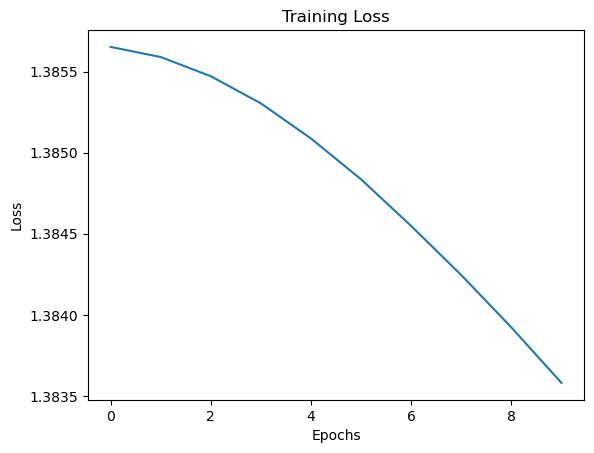

Precisión global: 25.0000%


In [44]:
# Instanciamos la red
net = Net()

# Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Entrenamos la red
net.train(10, train_loader, criterion, optimizer, cuda=True)

# Calculamos la precisión global
precision = calcularPrecisionGlobal(net, train_loader, 4, cuda=True)
print("Precisión global: %.4f%%"%(precision))